In [1]:
!pip install librosa

In [ ]:
!pip install pandas

In [1]:
import librosa
from librosa import display

data, sampling_rate = librosa.load("Ravdess/03-01-01-01-01-01-21.wav")

Test to see if dataset can be used

In [1]:
%pylab inline
import os
import glob
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampling_rate)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


NameError: name 'librosa' is not defined

<Figure size 1200x400 with 0 Axes>

In [3]:
!pip install soundfile


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install seaborn matplotlib

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ----------------------- ---------------- 174.1/294.9 kB 3.5 MB/s eta 0:00:01
   --------------------------- ------------ 204.8/294.9 kB 2.1 MB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.8 MB/s eta 0:00:00


In [8]:
!pip install tensorflow

     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5/57.5 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/65.5 kB ? eta -:--:--
     ---------------------------------------- 65.5/65.5 kB 3.7 MB/s eta 0:00:00
  Using cached protobuf-4.25.1-cp310-abi3-win_amd64.whl.metadata (541 bytes)
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ---------------------------------------  1.5/1.5 MB 31.4 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 31.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/181.3 kB ? eta -:--:--
     ---------------------------------------- 181.3/181.3 kB ? eta 0:00:00
     ---------------------------------------- 0.0/151.7 kB ? eta -:--:--
     ---------------------------------------- 151.7/151.7 kB ? eta 0:00:00
   ---------------------------------------- 0.0/300.9 MB ? eta -:--:--
   --------------------

In [11]:
!pip install np_utils

     ---------------------------------------- 0.0/62.0 kB ? eta -:--:--
     ---------------------------------------- 62.0/62.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56449 sha256=f3e511fc8c578b6b785db4bd321d8430b359afe09fb4f38826cdf079ea15ceec
  Stored in directory: c:\users\mirza\appdata\local\pip\cache\wheels\b6\c7\50\2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [1]:
import soundfile
import numpy as np
import librosa
import glob
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Input, Flatten, Dropout, Activation, Dense, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, LSTM, SimpleRNN, TimeDistributed
from keras.models import Model, load_model, save_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def extract_features(file_name, **kwargs):
    
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        if X.ndim >= 2:
            X = np.mean(X, 1)
        sample_rate = sound_file.samplerate
        result = np.array([])
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr = sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectogram(X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
    return result

In [3]:
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Only Need These Emotions
UseEmotions = {
    "neutral",
    "calm",
    "happy",
    "sad",
    "angry",
}

In [4]:
def load_data(test_size=0.2, val_size=0.1):
    X, y = [], []
    for file in glob.glob("Ravdess/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in UseEmotions:
            continue
        # extract speech features
        features = extract_features(file, mfcc=True, chroma=False, mel=False)
        # add to data
        X.append(features)
        y.append(emotion)
    # split the data into training, validation, and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=8)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size), random_state=8)
    # return training, validation, and testing sets
    return np.array(X_train), np.array(X_val), np.array(X_test), np.array(y_train), np.array(y_val), np.array(y_test)



In [5]:
X_train, X_val, X_test, y_train1, y_val1, y_test1 = load_data(test_size=0.15, val_size=0.15)

In [6]:
# print some details
# number of samples in training data
print("[Training samples:", X_train.shape[0])
# number of samples in testing data
print("Testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted 
# using extract_features() function
print("Features:", X_train.shape[1])

lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train1))
y_val = to_categorical(lb.fit_transform(y_val1))
y_test = to_categorical(lb.fit_transform(y_test1))

# Reshape data for CNN and DNN
x_traincnn = np.expand_dims(X_train, axis=2)
x_valcnn = np.expand_dims(X_val, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

x_traindnn = np.expand_dims(X_train, axis=1)
x_valdnn = np.expand_dims(X_val, axis=1)
x_testdnn = np.expand_dims(X_test, axis=1)


print(x_traincnn.shape) 
print(x_testcnn.shape)
print(x_valcnn.shape)
print(x_traincnn.shape[2])
print(y_train.shape) 
print(y_test.shape)
print(y_val.shape)
print(x_traindnn.shape)
print(x_testdnn.shape)

[Training samples: 1184
Testing samples: 254
Features: 40
(1184, 40, 1)
(254, 40, 1)
(254, 40, 1)
1
(1184, 5)
(254, 5)
(254, 5)
(1184, 1, 40)
(254, 1, 40)


CNN MODEL




Epoch 1/100


37/37 [==============================] - 2s 12ms/step - loss: 2.5982 - accuracy: 0.2416 - val_loss: 2.3081 - val_accuracy: 0.2126
Epoch 2/100
37/37 [==============================] - 0s 6ms/step - loss: 2.2945 - accuracy: 0.2998 - val_loss: 2.5194 - val_accuracy: 0.2008
Epoch 3/100
37/37 [==============================] - 0s 5ms/step - loss: 2.1197 - accuracy: 0.3505 - val_loss: 2.2050 - val_accuracy: 0.2992
Epoch 4/100
37/37 [==============================] - 0s 6ms/step - loss: 2.0045 - accuracy: 0.3784 - val_loss: 1.9482 - val_accuracy: 0.4094
Epoch 5/100
37/37 [==============================] - 0s 7ms/step - loss: 1.8735 - accuracy: 0.4062 - val_loss: 1.7909 - val_accuracy: 0.4724
Epoch 6/100
37/37 [==============================] - 0s 6ms/step - loss: 1.7970 - accuracy: 0.4358 - val_loss: 1.7282 - val_accuracy: 0.4016
Epoch 7/100
37/37 [==============================] - 0s 7ms/step - loss: 1.7364 - accuracy: 0.4603 - val_loss: 1.5738 - val_accuracy: 0.5000
Epoch 8

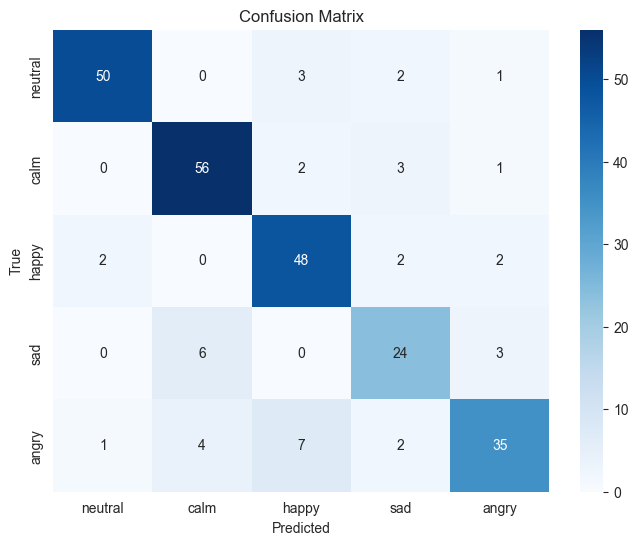

In [7]:
model = Sequential()

model.add(Conv1D(16,5,padding='same',activation='relu',input_shape=(40,1), kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv1D(32,5,padding='same',activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv1D(64,5,padding='same',activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(units=5,activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])


cnnhistory=model.fit(x_traincnn, np.array(y_train), batch_size=32, epochs=100, validation_data=(x_valcnn, np.array(y_val)))
model.summary()
print("Accuracy: {:.2f}%".format(cnnhistory.history['accuracy'][-1]*100))
print("Validation Accuracy: {:.2f}%".format(cnnhistory.history['val_accuracy'][-1]*100))

y_pred_probabilities = model.predict(x_testcnn)
y_pred = np.argmax(y_pred_probabilities, axis=1)

y_test_single_label = lb.inverse_transform(np.argmax(y_test, axis=1))

y_test_numeric = lb.transform(y_test_single_label)

# Calculate F1 score
f1 = f1_score(y_test_numeric, y_pred, average='weighted')

# Calculate precision
precision = precision_score(y_test_numeric, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_test_numeric, y_pred, average='weighted')

print("Precision: %.4f" %  precision)
print("Recall: %.4f" %  recall)

print("F1 Score: %.4f" %  f1)
# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['neutral', 'calm', 'happy','sad','angry'], yticklabels=['neutral', 'calm', 'happy','sad','angry'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


LSTM MODEL

Epoch 1/100
37/37 [==============================] - 1s 14ms/step - loss: 15.7010 - accuracy: 0.2272 - val_loss: 1.6181 - val_accuracy: 0.1929
Epoch 2/100
37/37 [==============================] - 0s 8ms/step - loss: 1.5609 - accuracy: 0.2297 - val_loss: 1.6275 - val_accuracy: 0.2008
Epoch 3/100
37/37 [==============================] - 0s 8ms/step - loss: 1.5627 - accuracy: 0.2948 - val_loss: 1.5577 - val_accuracy: 0.2913
Epoch 4/100
37/37 [==============================] - 0s 9ms/step - loss: 1.5084 - accuracy: 0.3302 - val_loss: 1.5333 - val_accuracy: 0.3031
Epoch 5/100
37/37 [==============================] - 0s 8ms/step - loss: 1.4851 - accuracy: 0.3446 - val_loss: 1.4086 - val_accuracy: 0.3701
Epoch 6/100
37/37 [==============================] - 0s 8ms/step - loss: 1.3540 - accuracy: 0.4139 - val_loss: 1.3131 - val_accuracy: 0.4370
Epoch 7/100
37/37 [==============================] - 0s 8ms/step - loss: 1.3052 - accuracy: 0.4367 - val_loss: 1.2755 - val_accuracy: 0.4252
Epoch 8/100

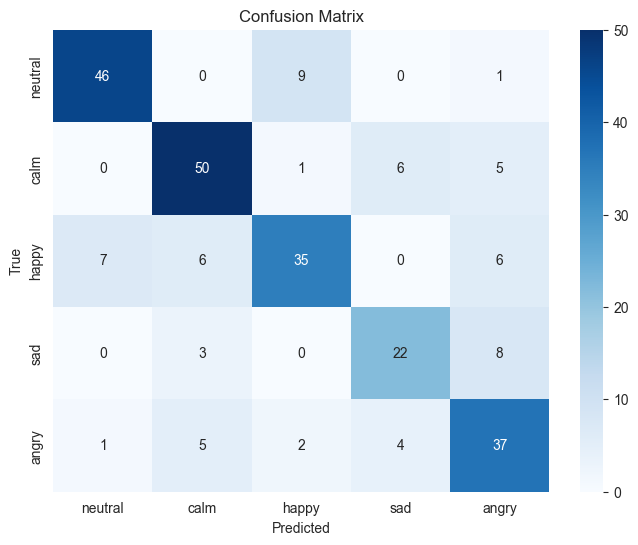

In [14]:
model_lstm = Sequential()

model_lstm.add(LSTM(50, activation='relu', input_shape=(40,1)))
model_lstm.add(Dense(5, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])


lstmhistory=model_lstm.fit(x_traincnn, np.array(y_train), batch_size=32, epochs=100, validation_data=(x_valcnn, np.array(y_val)))
print("Accuracy: {:.2f}%".format(lstmhistory.history['accuracy'][-1]*100))
print("Validation Accuracy: {:.2f}%".format(lstmhistory.history['val_accuracy'][-1]*100))

y_pred_lstm_prob = model_lstm.predict(x_testcnn)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)

y_test_lstm_label = lb.inverse_transform(np.argmax(y_test, axis=1))

y_lstm_numeric = lb.transform(y_test_lstm_label)

# Calculate F1 score
f1 = f1_score(y_lstm_numeric, y_pred_lstm, average='weighted')

# Calculate precision
precision = precision_score(y_lstm_numeric, y_pred_lstm, average='weighted')

# Calculate recall
recall = recall_score(y_lstm_numeric, y_pred_lstm, average='weighted')

print("Precision: %.4f" % precision)
print("Recall:  %.4f" % recall)

print("F1 Score: %.4f" % f1)
# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_lstm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['neutral', 'calm', 'happy','sad','angry'], yticklabels=['neutral', 'calm', 'happy','sad','angry'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

DNN MODEL

Epoch 1/100
37/37 [==============================] - 2s 8ms/step - loss: 4.7014 - accuracy: 0.2171 - val_loss: 3.7192 - val_accuracy: 0.2047
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 3.4593 - accuracy: 0.2483 - val_loss: 3.2102 - val_accuracy: 0.3583
Epoch 3/100
37/37 [==============================] - 0s 3ms/step - loss: 3.0223 - accuracy: 0.3074 - val_loss: 2.8640 - val_accuracy: 0.3740
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 2.7549 - accuracy: 0.3285 - val_loss: 2.7363 - val_accuracy: 0.3346
Epoch 5/100
37/37 [==============================] - 0s 3ms/step - loss: 2.5905 - accuracy: 0.3193 - val_loss: 2.4996 - val_accuracy: 0.3937
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 2.4436 - accuracy: 0.3894 - val_loss: 2.3316 - val_accuracy: 0.4370
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 2.3542 - accuracy: 0.3995 - val_loss: 2.2497 - val_accuracy: 0.5354
Epoch 8/100
3

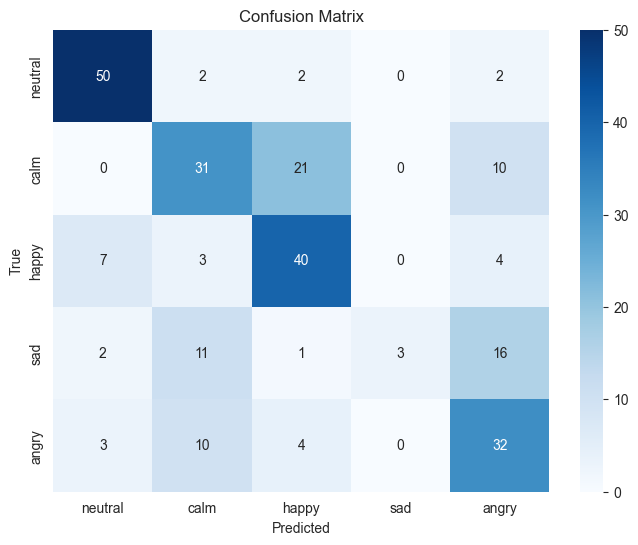

In [16]:
model_dnn = Sequential()
model_dnn.add(Flatten())
model_dnn.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(40, 1)))
model_dnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_dnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_dnn.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_dnn.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model_dnn.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))

model_dnn.add(Dense (5, activation='softmax'))

model_dnn.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])

dnnhistory=model_dnn.fit(x_traindnn, np.array(y_train), batch_size=32, epochs=100, validation_data=(x_valdnn, np.array(y_val)))
print("Accuracy: {:.2f}%".format(dnnhistory.history['accuracy'][-1]*100))
print("Validation Accuracy: {:.2f}%".format(dnnhistory.history['val_accuracy'][-1]*100))

y_pred_dnn_prob = model_dnn.predict(x_testdnn)
y_pred_dnn = np.argmax(y_pred_dnn_prob, axis=1)

y_test_dnn_label = lb.inverse_transform(np.argmax(y_test, axis=1))

y_dnn_numeric = lb.transform(y_test_dnn_label)

# Calculate F1 score
f1 = f1_score(y_dnn_numeric, y_pred_dnn, average='weighted')

# Calculate precision
precision = precision_score(y_dnn_numeric, y_pred_dnn, average='weighted')

# Calculate recall
recall = recall_score(y_dnn_numeric, y_pred_dnn, average='weighted')

print("Precision: %.4f" % precision)
print("Recall:  %.4f" % recall)

print("F1 Score: %.4f" % f1)
# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_dnn)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['neutral', 'calm', 'happy','sad','angry'], yticklabels=['neutral', 'calm', 'happy','sad','angry'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

CNN-LSTM HYBRID MODEL

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 40, 16)            96        
                                                                 
 lstm_4 (LSTM)               (None, 40, 50)            13400     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 20, 50)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 20, 32)            8032      
                                                                 
 batch_normalization_4 (Bat  (None, 20, 32)            128       
 chNormalization)                                                
                                                                 
 lstm_5 (LSTM)               (None, 20, 50)           

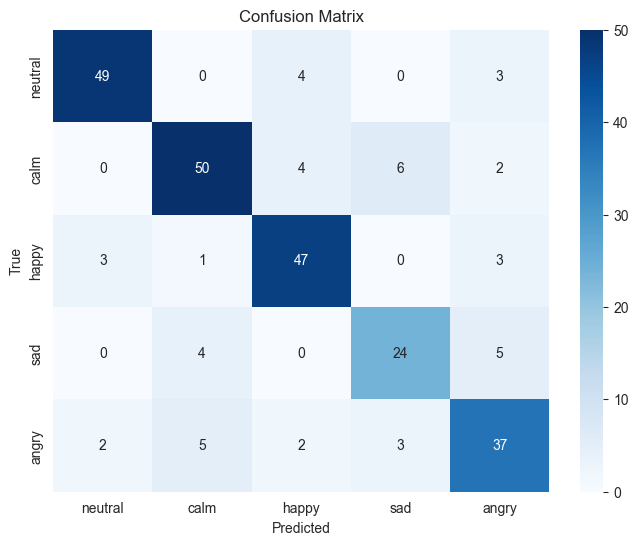

In [13]:
model_hybrid = Sequential()

model_hybrid.add(Conv1D(16, 5, activation='relu', padding='same', input_shape=(40, 1), kernel_regularizer=l2(0.01)))
model_hybrid.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.1))
model_hybrid.add(MaxPooling1D(2))
model_hybrid.add(Conv1D(32, 5, activation="relu", padding='same', kernel_regularizer=l2(0.01)))
model_hybrid.add(BatchNormalization()) 
model_hybrid.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.1))
model_hybrid.add(MaxPooling1D(2))

model_hybrid.add(Conv1D(64, 5, activation="relu", padding='same', kernel_regularizer=l2(0.01)))
model_hybrid.add(BatchNormalization()) 
model.add(Dropout(0.1))
model_hybrid.add(Flatten()) 

model_hybrid.add(Dense(5, activation='softmax'))

model_hybrid.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_hybrid.summary()


hybridhistory = model_hybrid.fit(x_traincnn, np.array(y_train), batch_size=32, epochs=100, validation_data=(x_valcnn, np.array(y_val)))
print("Accuracy: {:.2f}%".format(hybridhistory.history['accuracy'][-1]*100))
print("Validation Accuracy: {:.2f}%".format(hybridhistory.history['val_accuracy'][-1]*100))

y_pred_hybrid_prob = model_hybrid.predict(x_testcnn)
y_pred_hybrid = np.argmax(y_pred_hybrid_prob, axis=1)

y_test_hybrid_label = lb.inverse_transform(np.argmax(y_test, axis=1))

y_hybrid_numeric = lb.transform(y_test_hybrid_label)

# Calculate F1 score
f1 = f1_score(y_hybrid_numeric, y_pred_hybrid, average='weighted')

# Calculate precision
precision = precision_score(y_hybrid_numeric, y_pred_hybrid, average='weighted')

# Calculate recall
recall = recall_score(y_hybrid_numeric, y_pred_hybrid, average='weighted')

print("Precision: %.4f" % precision)
print("Recall:  %.4f" % recall)

print("F1 Score: %.4f" % f1)
# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_hybrid)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['neutral', 'calm', 'happy','sad','angry'], yticklabels=['neutral', 'calm', 'happy','sad','angry'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define models and their corresponding metrics
models = {
    'CNN': {'model': model, 'x_test': x_testcnn, 'y_test': y_test},
    'LSTM': {'model': model_lstm, 'x_test': x_testcnn, 'y_test': y_test},
    'DNN': {'model': model_dnn, 'x_test': x_testdnn, 'y_test': y_test},
    'CNN-LSTM Hybrid': {'model': model_hybrid, 'x_test': x_testcnn, 'y_test': y_test}
}

# Calculate evaluation metrics for each model
metrics = {}
for model_name, model_data in models.items():
    model = model_data['model']
    x_test = model_data['x_test']
    y_test = model_data['y_test']
    
    y_pred = np.argmax(model.predict(x_test), axis=1)
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    
    metrics[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

# Assign ranks to each model based on each metric
ranks = {metric: {model_name: rank for rank, (model_name, _) in enumerate(sorted(metrics.items(), key=lambda x: x[1][metric], reverse=True), start=1)} for metric in metrics['CNN'].keys()}

# Calculate average rank for each model across all metrics
average_ranks = {model_name: sum(rank[model_name] for rank in ranks.values()) / len(ranks) for model_name in models}

# Rank models based on average rank
sorted_models = sorted(average_ranks.keys(), key=lambda x: average_ranks[x])

# Print results
print("Model Rankings:")
for rank, model_name in enumerate(sorted_models, start=1):
    print(f"{rank}. {model_name}: Average Rank = {average_ranks[model_name]:.2f}")


8/8 [==============================] - 0s 6ms/step
Model Rankings:
1. CNN: Average Rank = 1.00
2. CNN-LSTM Hybrid: Average Rank = 2.00
3. LSTM: Average Rank = 3.00
4. DNN: Average Rank = 4.00


In [7]:
print("Accuracy: {:.2f}%".format(cnnhistory.history['accuracy'][-1]*100))

NameError: name 'cnnhistory' is not defined

In [18]:
cnn_model_path = 'model/CNN_model.keras'
model.save(cnn_model_path)
print('Saved CNN model at %s' % cnn_model_path)

Saved CNN model at model/CNN_model.keras


In [19]:
cnn_model_json = model.to_json()
with open("model/CNN_model.json", "w") as json_file:
    json_file.write(cnn_model_json)
    print('Saved CNN model architecture in JSON format')

Saved CNN model architecture in JSON format


In [34]:
import pandas as pd
testing = extract_features('Test Sad.wav', mfcc=True, chroma=False, mel=False)
live = testing
live = pd.DataFrame(live)
live = live.stack().to_frame().T

In [35]:
live

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-240.486786,154.460938,35.009628,31.2286,-5.096307,15.597924,-15.864566,6.378434,-3.21226,-11.478881,...,-2.901082,-5.636379,-4.163357,-2.501443,-0.018728,-2.04518,-3.295647,-6.834739,-5.849089,-4.523181


In [36]:
input_test = np.expand_dims(live, axis=2)

In [37]:
input_test.shape

(1, 40, 1)

In [38]:
from keras.models import model_from_json
json_file = open('model/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/CNN_model.keras")
print("Loaded model from disk")

opt = keras.optimizers.RMSprop(learning_rate=0.0001)

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#score = loaded_model.evaluate(, y_test, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


preds = loaded_model.predict(input_test, 
                         batch_size=32, 
                         verbose=1)

Loaded model from disk
1/1 [==============================] - 1s 1s/step


In [39]:
preds1=preds.argmax(axis=1)

abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform(abc))

preddf = pd.DataFrame({'predictedvalues': predictions})

In [40]:
preddf

,predictedvalues
0,sad
